In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances, rbf_kernel, laplacian_kernel
import pandas as pd
import numpy as np
from sklearn import preprocessing
import random

In [ ]:
# bad distances: linear_kernel, polynomial_kernel, sigmoid_kernel
# good distances: cosine_similarity/cosine_distance, euclidean_distances, rbf_kernel, laplacian_kernel

In [ ]:
# data reading
DATA_PATH = "numbeo.csv"
df = pd.read_csv(DATA_PATH)

# data preprocessing
df['id'] = df['CountryName'] + "#" + df['CityName']
cities_features = preprocessing.StandardScaler().fit_transform(df.drop(['CountryName', 'CityName', 'id'],axis=1).values)

cities_features.shape

(764, 30)

In [ ]:
def get_similarity_matr(features):

    #computing normilized desired distances from given features
    cos_dis = cosine_distances(features, features)
    cos_dis = 1.0 - (cos_dis / np.max(cos_dis))

    rbf_ker = rbf_kernel(features, features)
    rbf_ker = rbf_ker / np.max(rbf_ker)

    lap_ker = laplacian_kernel(features, features)
    lap_ker = lap_ker / np.max(lap_ker)

    euc_dis = euclidean_distances(features, features)
    euc_dis = 1.0 - (euc_dis / np.max(euc_dis))

    similarity_matrix = np.zeros(cos_dis.shape)

    # averaging distances
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):

            similarity_matrix[i,j] = (cos_dis[i, j] + rbf_ker[i, j] + 
                                      lap_ker[i, j] + euc_dis[i, j]) / 4.0

    return similarity_matrix

In [ ]:
similarity_matrix = get_similarity_matr(cities_features)

In [ ]:
mapping = pd.Series(df.index, index=df['id'])
print(mapping)

id
Albania#Tirana                0
Algeria#Algiers               1
Angola#Luanda                 2
Argentina#Buenos Aires        3
Argentina#Cordoba             4
                           ... 
Venezuela#Caracas           759
Vietnam#Da Nang             760
Vietnam#Hanoi               761
Vietnam#Ho Chi Minh City    762
Zimbabwe#Harare             763
Length: 764, dtype: int64


In [ ]:
rand = random.choice(mapping)
mapping.index[rand]

'United Kingdom#Birmingham'

In [ ]:
0 % 10

0

In [ ]:
def get_similarity_score(id, mapping, similarity_matrix):
    try:
        index = mapping[id]
    except:
        print("ERROR: Wrong input city ID")
        return 1
    similarity_score = list(enumerate(similarity_matrix[index]))
    return similarity_score

In [ ]:
similarity_score = get_similarity_score('Russia#Moscow', mapping, similarity_matrix)

In [ ]:
def recsys_top_results(similarity_score, df, user_cities_list, user_seen_list=[]):
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    #similarity_score = similarity_score[1:25]
    city_indeces = [i[0] for i in similarity_score]
    top_cities = [[x, y[1]] for x, y in zip(df['id'].iloc[city_indeces], similarity_score) if x not in user_cities_list and x not in user_seen_list]
    return top_cities

In [ ]:
recsys_top_results(similarity_score, df, ['Russia#Moscow'])

[['Russia#Saint Petersburg', 0.8678341134574866],
 ['Russia#Sochi', 0.7992148345002578],
 ['Russia#Krasnodar', 0.7524996042717704],
 ['Russia#Kazan', 0.7426671531056478],
 ['Russia#Samara', 0.7371541580031618],
 ['Russia#Vladivostok', 0.7349797890743488],
 ['China#Hangzhou', 0.721555804011487],
 ['Italy#Rome', 0.7165138337758609],
 ['Poland#Warsaw', 0.7141223441268015],
 ['Russia#Perm', 0.7125010299094581],
 ['Russia#Novosibirsk', 0.7124843160568393],
 ['China#Xiamen', 0.7102706706208064],
 ['China#Zhuhai', 0.6969064859744706],
 ['Russia#Khabarovsk', 0.6956529501108862],
 ['Russia#Yekaterinburg', 0.6926701114754679],
 ['Panama#Panama City', 0.6926076165009112],
 ['China#Tianjin', 0.6923483017655068],
 ['Russia#Rostov-na-donu', 0.6868923030488955],
 ['China#Guangzhou', 0.6863319090583895],
 ['Thailand#Bangkok', 0.6819921543221635],
 ['Russia#Voronezh', 0.6790397289451091],
 ['Mexico#Mexico City', 0.6779784684211583],
 ['Qatar#Doha', 0.6778220753329463],
 ['China#Shanghai', 0.67500501720

## Example of use

User input data

In [ ]:
INPUT_USER_CITIES_LIST = []
PRIORITIES = [] # for future work
USER_SIMILARITY_SCORES = []

Cities data

In [ ]:
CITIES_SIM_MATR = get_similarity_matr(cities_features)
CITIES_MAPPING = pd.Series(df.index, index=df['id'])

Function for scores update with multiple cities input

In [ ]:
def update_scores(new_city, user_city_list=INPUT_USER_CITIES_LIST,
                  prev_sim_scores=USER_SIMILARITY_SCORES,
                  cities_sim_matr=CITIES_SIM_MATR,
                  cities_mapping=CITIES_MAPPING):

    new_sim_scores = get_similarity_score(new_city, cities_mapping, cities_sim_matr)
    
    if new_sim_scores == 1:
        return 1, 1
    
    if len(user_city_list) != 0:
        scores = []
        for i in range(len(prev_sim_scores)):
            scores.append((i, new_sim_scores[i][1] + prev_sim_scores[i][1]))
        
        new_sim_scores=scores

    user_city_list.append(new_city)

    return user_city_list, new_sim_scores

User chooses first city

In [ ]:
user_input = 'Russia#Moscow'
INPUT_USER_CITIES_LIST, USER_SIMILARITY_SCORES = update_scores(new_city=user_input, 
                                                               user_city_list=INPUT_USER_CITIES_LIST,
                                                               prev_sim_scores=USER_SIMILARITY_SCORES,
                                                               cities_sim_matr=CITIES_SIM_MATR,
                                                               cities_mapping=CITIES_MAPPING)

And gets new recommendations

In [ ]:
recsys_top_results(USER_SIMILARITY_SCORES, df, INPUT_USER_CITIES_LIST)

[['Russia#Saint Petersburg', 0.8678341134574866],
 ['Russia#Sochi', 0.7992148345002578],
 ['Russia#Krasnodar', 0.7524996042717704],
 ['Russia#Kazan', 0.7426671531056478],
 ['Russia#Samara', 0.7371541580031618],
 ['Russia#Vladivostok', 0.7349797890743488],
 ['China#Hangzhou', 0.721555804011487],
 ['Italy#Rome', 0.7165138337758609],
 ['Poland#Warsaw', 0.7141223441268015],
 ['Russia#Perm', 0.7125010299094581],
 ['Russia#Novosibirsk', 0.7124843160568393],
 ['China#Xiamen', 0.7102706706208064],
 ['China#Zhuhai', 0.6969064859744706],
 ['Russia#Khabarovsk', 0.6956529501108862],
 ['Russia#Yekaterinburg', 0.6926701114754679],
 ['Panama#Panama City', 0.6926076165009112],
 ['China#Tianjin', 0.6923483017655068],
 ['Russia#Rostov-na-donu', 0.6868923030488955],
 ['China#Guangzhou', 0.6863319090583895],
 ['Thailand#Bangkok', 0.6819921543221635],
 ['Russia#Voronezh', 0.6790397289451091],
 ['Mexico#Mexico City', 0.6779784684211583],
 ['Qatar#Doha', 0.6778220753329463],
 ['China#Shanghai', 0.67500501720

In [ ]:
recsys_top_results(USER_SIMILARITY_SCORES, df, INPUT_USER_CITIES_LIST)[0]


['Russia#Saint Petersburg', 0.8678341134574866]

In [ ]:
mapping['Russia#Saint Petersburg']

509

User chooses another city

In [ ]:
user_input = 'Russia#Krasnoyarsk'
INPUT_USER_CITIES_LIST, USER_SIMILARITY_SCORES = update_scores(new_city=user_input, 
                                                               user_city_list=INPUT_USER_CITIES_LIST,
                                                               prev_sim_scores=USER_SIMILARITY_SCORES,
                                                               cities_sim_matr=CITIES_SIM_MATR,
                                                               cities_mapping=CITIES_MAPPING)

And gets new recommendations

In [ ]:
recsys_top_results(USER_SIMILARITY_SCORES, df, INPUT_USER_CITIES_LIST)

[['Russia#Saint Petersburg', 1.650679307195671],
 ['Russia#Omsk', 1.6136683178767572],
 ['Russia#Novosibirsk', 1.6079311959926124],
 ['Russia#Perm', 1.5722918617615331],
 ['Russia#Vladivostok', 1.5667838524456015],
 ['Russia#Kazan', 1.5638969014680884],
 ['Russia#Krasnodar', 1.5616035152345262],
 ['Russia#Samara', 1.5613157181041097],
 ['Russia#Yekaterinburg', 1.5479830832000856],
 ['Russia#Rostov-na-donu', 1.5318243385769037],
 ['Russia#Voronezh', 1.510405853543986],
 ['Kazakhstan#Almaty', 1.4731356494247771],
 ['Indonesia#Jakarta', 1.4635937077781889],
 ['Georgia#Tbilisi', 1.4602862442735274],
 ['Cambodia#Phnom Penh', 1.4529354881711714],
 ['Romania#Bucharest', 1.4509171156934828],
 ['Russia#Sochi', 1.4396015326967881],
 ['China#Tianjin', 1.4388916481369949],
 ['Serbia#Belgrade', 1.4360414306972569],
 ['Hungary#Budapest', 1.4354972456139106],
 ['Azerbaijan#Baku', 1.4315528265425974],
 ['Brazil#Sao Paulo', 1.4313232114122987],
 ['Mexico#Mexico City', 1.4296032997958044],
 ['Ukraine#Ki

And another city....

In [ ]:
user_input = 'Kazakhstan#Almaty'
INPUT_USER_CITIES_LIST, USER_SIMILARITY_SCORES = update_scores(new_city=user_input, 
                                                               user_city_list=INPUT_USER_CITIES_LIST,
                                                               prev_sim_scores=USER_SIMILARITY_SCORES,
                                                               cities_sim_matr=CITIES_SIM_MATR,
                                                               cities_mapping=CITIES_MAPPING)

And gets new recommendations

In [ ]:
recsys_top_results(USER_SIMILARITY_SCORES, df, INPUT_USER_CITIES_LIST)

[['Russia#Perm', 2.433038624880756],
 ['Russia#Omsk', 2.421505153994494],
 ['Russia#Novosibirsk', 2.4176246056920525],
 ['Russia#Rostov-na-donu', 2.381301550528926],
 ['Russia#Samara', 2.3668043208409535],
 ['Russia#Saint Petersburg', 2.3651569488187913],
 ['Russia#Yekaterinburg', 2.360996122100799],
 ['Russia#Kazan', 2.3542776035222914],
 ['Russia#Krasnodar', 2.3089435903456357],
 ['Russia#Voronezh', 2.3058307923049046],
 ['Kyrgyzstan#Bishkek', 2.3050643975910226],
 ['Russia#Vladivostok', 2.291961506936048],
 ['Ukraine#Dnipro', 2.2572318808554415],
 ['Azerbaijan#Baku', 2.255398370622588],
 ['Cambodia#Phnom Penh', 2.254907158636258],
 ['Indonesia#Jakarta', 2.2541437160148146],
 ['Ukraine#Kiev (Kyiv)', 2.252446235268007],
 ['Georgia#Tbilisi', 2.249771412564738],
 ['Brazil#Vitoria', 2.2417542018773347],
 ['Mongolia#Ulaanbaatar', 2.227650936167268],
 ['Egypt#Cairo', 2.22619833687247],
 ['Russia#Irkutsk', 2.2153100980708667],
 ['Mexico#Monterrey', 2.208240339329269],
 ['Brazil#Sao Paulo', 

In [ ]:
SEEN_USER_CITIES_LIST = []

In [ ]:
def get_recs():
    city_id = -1
    city_name = ''
    description = ''

    if len(INPUT_USER_CITIES_LIST) % 10 == 0:
        while True:
            city_id = random.choice(CITIES_MAPPING)
            city_name = CITIES_MAPPING.index[city_id]
            if city_id not in INPUT_USER_CITIES_LIST:
                SEEN_USER_CITIES_LIST.append(city_name)
                break
    else:
        city_name = recsys_top_results(USER_SIMILARITY_SCORES, df, INPUT_USER_CITIES_LIST, SEEN_USER_CITIES_LIST)[0]
        SEEN_USER_CITIES_LIST.append(city_name)
        city_id = CITIES_MAPPING[city_name]

    return {"city_id": city_id,
            "city_name": city_name,
            "description": description}

In [ ]:
get_recs()

## Visualizations

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from textwrap import wrap

import matplotlib.patches as mpl_patches

In [ ]:
themes_dict = {}
themes_dict['catering'] = {}
themes_dict['catering']['color'] = '#d18f0b'
themes_dict['catering']['title'] = 'Public Catering'
themes_dict['catering']['xlabel'] = 'Cost, $'
themes_dict['catering']['features'] = ['Cappuccino (regular)',
                                       'McMeal at McDonalds (or Equivalent Combo Meal)',
                                       'Meal, Inexpensive Restaurant',
                                       'Meal for 2 People, Mid-range Restaurant, Three-course']
themes_dict['transport'] = {}
themes_dict['transport']['color'] = '#6399d5'
themes_dict['transport']['title'] = 'Transport'
themes_dict['transport']['xlabel'] = 'Cost, $'
themes_dict['transport']['features'] = ['Taxi 1 mile (Normal Tariff)',
                                        'One-way Ticket (Local Transport)',   
                                        'Taxi Start (Normal Tariff)', 
                                        'Gasoline (1 gallon)', 
                                        'Monthly Pass (Regular Price)']
themes_dict['apartment'] = {}
themes_dict['apartment']['color'] = '#a6244b'
themes_dict['apartment']['title'] = 'Apartments'
themes_dict['apartment']['xlabel'] = 'Cost, $'
themes_dict['apartment']['features'] = ['Price per Square Feet to Buy Apartment Outside of Centre',
                                        'Price per Square Feet to Buy Apartment in City Centre',  
                                        'Apartment (1 bedroom) Outside of Centre', 
                                        'Apartment (3 bedrooms) Outside of Centre', 
                                        'Apartment (1 bedroom) in City Centre',
                                        'Apartment (3 bedrooms) in City Centre']
themes_dict['edu/fin'] = {}
themes_dict['edu/fin']['color'] = '#86bf91'
themes_dict['edu/fin']['title'] = 'Education & Finance'
themes_dict['edu/fin']['xlabel'] = 'Amount / Cost, $'
themes_dict['edu/fin']['features'] = ['Average Monthly Net Salary (After Tax)',
                                      'Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child', 
                                      'International Primary School, Yearly for 1 Child']
themes_dict['life-quality'] = {}
themes_dict['life-quality']['color'] = '#a64d79'
themes_dict['life-quality']['title'] = 'Quality of Life Factors'
themes_dict['life-quality']['xlabel'] = 'Rate, %'
themes_dict['life-quality']['features'] = ['Level of crime', 
                                           'Skill and competency of medical staff', 
                                           'Air Pollution', 
                                           'Drinking Water Pollution and Inaccessibility', 
                                           'Dissatisfaction with Green and Parks in the City']
themes_dict['other'] = {}
themes_dict['other']['color'] = '#bb9861'
themes_dict['other']['title'] = 'Other Information'
themes_dict['other']['xlabel'] = 'Cost, $'
themes_dict['other']['features'] = ['Cigarettes 20 Pack (Marlboro)',  
                                    'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)',
                                    'Basic (Electricity, Heating, Cooling, Water, Garbage) for 915 sq ft Apartment',]

In [ ]:
def visualize_theme(theme, city_id, themes_dict=themes_dict, data=df, path=None):

    # function to get barh matplotlib visualization of group of features.     #
    # theme - group of features (catering, transport, apartment, )            #
    # city_id - city to get info for, data - pd DataFrame with data,          #
    # path - path to a location where to store plot image                     #
    # (if path == None then just plot graph with no image saving)             #

    city_name, country_name = city_id.split('#')
    features = themes_dict[theme]['features']
    color = themes_dict[theme]['color']
    title = city_name + ', ' + country_name + ' - ' + themes_dict[theme]['title']
    xlabel = themes_dict[theme]['xlabel']

    sub_df = data[features][data['id']==city_id]
    
    fig, ax = plt.subplots(figsize=(10,5))

    y = ['\n'.join(wrap(x, 30)) for x in sub_df.columns]
    x = list(sub_df.values[0])

    ax.barh(y, x, color=color, zorder=2)

    for i, v in enumerate(x):
        ax.text(v + 3, i, str(v), va='center', 
                color=color, fontweight='bold', size=15)

    
    if theme == 'edu_fin':
        # create a list with two empty handles (or more if needed)
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                        lw=0, alpha=0)] * 2
        # create the corresponding number of labels (= the text you want to display)
        labels = []
        labels.append(str(data['Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate'][data['id']==city_id].values[0])+'%')
        labels.append('Mortgage Interest Rate Yearly,\nfor 20 Years Fixed-Rate')
        # create the legend, supressing the blank space of the empty line symbol and the
        # padding between symbol and label by setting handlelenght and handletextpad
        leg = ax.legend(handles, labels, loc='lower right', fontsize=14, 
                        fancybox=True, framealpha=0.7, 
                        handlelength=0, handletextpad=0, facecolor='#f3fff5')
        label1, label2 = leg.get_texts()
        label1._fontproperties = label2._fontproperties.copy()
        label1.set_size(25)
        label1.set_color(color)
        label1.set_weight('bold')

    
    if theme == 'life-quality':
        # create a list with two empty handles (or more if needed)
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                        lw=0, alpha=0)] * 2
        # create the corresponding number of labels (= the text you want to display)
        labels = []
        labels.append(str(data['Quality of Life Index:'][data['id']==city_id].values[0]))
        labels.append('Quality of Life Index\n(0..240)')
        # create the legend, supressing the blank space of the empty line symbol and the
        # padding between symbol and label by setting handlelenght and handletextpad
        leg = ax.legend(handles, labels, loc='lower right', fontsize=14, 
                        fancybox=True, framealpha=0.7, 
                        handlelength=0, handletextpad=0, facecolor='#ffe9f4')
        label1, label2 = leg.get_texts()
        label1._fontproperties = label2._fontproperties.copy()
        label1.set_size(25)
        label1.set_color(color)
        label1.set_weight('bold')

        labels = []
        labels.append(str(data['Traffic Index:'][data['id']==city_id].values[0]))
        labels.append('Traffic Index')
        leg2 = ax.legend(handles, labels, loc='upper right', fontsize=14, 
                         fancybox=True, framealpha=0.7, 
                         handlelength=0, handletextpad=0, facecolor='#ffe9f4')
        ax.add_artist(leg)

        label1, label2 = leg2.get_texts()
        label1._fontproperties = label2._fontproperties.copy()
        label1.set_size(25)
        label1.set_color(color)
        label1.set_weight('bold')
        plt.xlim([0, max(x) + 62])
    
    
    # Despine
    plt.box(False)
    # Switch off ticks
    plt.tick_params(axis=u'both', which=u'both', length=0, labelsize=15)
    # Draw vertical axis lines
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', 
                   alpha=0.45, color='#cccccc', zorder=1)
    # Set x-axis label
    plt.xlabel(xlabel, labelpad=20, weight='bold', size=16)
    plt.title(title, weight='bold', size=16)
    # Format y-axis label
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

    if path != None:    
        plt.savefig(path + city_id + '_' + theme + '_' + '.png', bbox_inches='tight')
        plt.close(fig)

Food-related cost features visualization

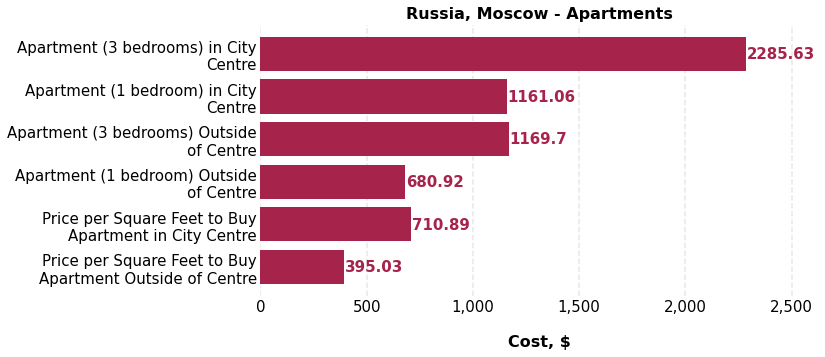

In [ ]:
city_id = 'Russia#Moscow'
theme = 'apartment'
visualize_theme(theme, city_id, themes_dict=themes_dict, data=df, path=None)

In [ ]:
visualize_theme(theme, city_id, themes_dict=themes_dict, data=df, path='')

Transport-related feature visualization

Apartment-related feature visualization

In [ ]:
def get_feature_grups():
    themes_dict = {}
    themes_dict['catering'] = {}
    themes_dict['catering']['color'] = '#d18f0b'
    themes_dict['catering']['title'] = 'Public Catering'
    themes_dict['catering']['xlabel'] = 'Cost, $'
    themes_dict['catering']['features'] = ['Cappuccino (regular)',
                                          'McMeal at McDonalds (or Equivalent Combo Meal)',
                                          'Meal, Inexpensive Restaurant',
                                          'Meal for 2 People, Mid-range Restaurant, Three-course']
    themes_dict['transport'] = {}
    themes_dict['transport']['color'] = '#6399d5'
    themes_dict['transport']['title'] = 'Transport'
    themes_dict['transport']['xlabel'] = 'Cost, $'
    themes_dict['transport']['features'] = ['Taxi 1 mile (Normal Tariff)',
                                            'One-way Ticket (Local Transport)',   
                                            'Taxi Start (Normal Tariff)', 
                                            'Gasoline (1 gallon)', 
                                            'Monthly Pass (Regular Price)']
    themes_dict['apartment'] = {}
    themes_dict['apartment']['color'] = '#a6244b'
    themes_dict['apartment']['title'] = 'Apartments'
    themes_dict['apartment']['xlabel'] = 'Cost, $'
    themes_dict['apartment']['features'] = ['Price per Square Feet to Buy Apartment Outside of Centre',
                                            'Price per Square Feet to Buy Apartment in City Centre',  
                                            'Apartment (1 bedroom) Outside of Centre', 
                                            'Apartment (3 bedrooms) Outside of Centre', 
                                            'Apartment (1 bedroom) in City Centre',
                                            'Apartment (3 bedrooms) in City Centre']
    themes_dict['edu/fin'] = {}
    themes_dict['edu/fin']['color'] = '#86bf91'
    themes_dict['edu/fin']['title'] = 'Education & Finance'
    themes_dict['edu/fin']['xlabel'] = 'Amount / Cost, $'
    themes_dict['edu/fin']['features'] = ['Average Monthly Net Salary (After Tax)',
                                          'Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child', 
                                          'International Primary School, Yearly for 1 Child']
    themes_dict['life-quality'] = {}
    themes_dict['life-quality']['color'] = '#a64d79'
    themes_dict['life-quality']['title'] = 'Quality of Life Factors'
    themes_dict['life-quality']['xlabel'] = 'Rate, %'
    themes_dict['life-quality']['features'] = ['Level of crime', 
                                              'Skill and competency of medical staff', 
                                              'Air Pollution', 
                                              'Drinking Water Pollution and Inaccessibility', 
                                              'Dissatisfaction with Green and Parks in the City']
    themes_dict['other'] = {}
    themes_dict['other']['color'] = '#bb9861'
    themes_dict['other']['title'] = 'Other Information'
    themes_dict['other']['xlabel'] = 'Cost, $'
    themes_dict['other']['features'] = ['Cigarettes 20 Pack (Marlboro)',  
                                        'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)',
                                        'Basic (Electricity, Heating, Cooling, Water, Garbage) for 915 sq ft Apartment',]
                                        
    return themes_dict                                        